### Building Hamiltonian

In [1]:
import os
import itertools
from itertools import combinations
import numpy as np
import scipy as sp
import sys
from scipy.sparse import csr_matrix, save_npz, load_npz
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.interpolate import Akima1DInterpolator
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
from operator import itemgetter
from collections import OrderedDict
import copy
import time


def flip(l0,l1):
    if (l0 == 1 and l1 == -1) or (l0 == -1 and l1 == 1):
         return [[0, 0]]
    if (l0 == 0 and l1 == 0):
        return [[1,-1],[-1,1]]
    else:
        return [[l1,l0]]
    
def find_state_index(state, basis_list):
    if state in basis_list:
        b = basis_list.index(state)
        return b
    else:
        return -1

def Honey_1nbr_bond(lx,ly):
    Ns = 2*lx*ly   # Total number of spins
    Nb = 3*lx*ly   # Total number of H-bonds (Honeycomb)

    bsites = [[0 for j in range(2)] for i in range(Nb)]

    bond = 0
    for y in range(ly):
        for x in range(lx):
            # This is a loop over unit cells, the honeycomb has one internal bond
            # and two external bonds per unit cell
            i = x + lx * y
            iN = x + lx * ((y + 1) % ly)
            iNW = (x + lx - 1) % lx + lx * ((y + 1) % ly)

            # internal bond
            bsites[bond][0] = 2 * i
            bsites[bond][1] = 2 * i + 1
            bond += 1

            # +y bond
            bsites[bond][0] = 2 * i + 1
            bsites[bond][1] = 2 * iN
            bond += 1

            # -x+y bond
            bsites[bond][0] = 2 * i + 1
            bsites[bond][1] = 2 * iNW
            bond += 1
            
    return bsites
        
def Honey_3nbr_bond(lx,ly):
    if lx==ly==2:
        return [[0,3],[1,2],[4,7],[5,6]]
    if lx == 3 and ly == 2:
        return [[0,3],[0,5],[2,1],[2,5],[4,3],[4,1],[6,11],[6,9],[8,7],[8,11],[10,9],[10,7]]
    
def mz_basis_list(lx,ly,s,mz):
    import itertools
    ls = [-1,0,1] if s == 1 else [0,1]
    Ns = 2*lx*ly           # Total number of spins
    basis_list = list(itertools.product(ls,repeat=Ns))
    mz_basis_list = []
    for bas in basis_list:
        summ = np.sum(bas)
        if summ == mz:
            mz_basis_list.append(bas)
    return mz_basis_list

def find_mz(lx,ly,s):
    import numpy as np
    Ns = 2*lx*ly           # Total number of spins
    if s == 1/2:
        mz_list = np.arange(-Ns/2,(Ns/2)+1,1)
        mz_set = set(mz_list)
    if s == 1:
        mz_list = np.arange(-Ns,Ns+1,1)
        mz_set = set(mz_list)
    return sorted(list(mz_set))

def Honey_ham_J1(lx,ly,s,J1,mz,TF):
    sparse = TF
    basis_list = mz_basis_list(lx,ly,s,mz)
    H_size = len(basis_list)
    nbr1_bonds = Honey_1nbr_bond(lx,ly)
    Ns = 2*lx*ly
    
    #creating empty hamiltonian matrix of dimension H_size*H_size
    if sparse != True:
        H = np.zeros((H_size,H_size), dtype = float)
    data = []; rows = []; cols = []
    
    for basis in basis_list:
        #print(f"basis= {basis}")
        ind1 =  find_state_index(basis,basis_list)
        diag_energy = 0
            
        for bond in nbr1_bonds:
            s1 = basis[bond[0]]
            s2 = basis[bond[1]]
            
            diag_energy += J1*s1*s2
            
            if (s1 != s2) or (s1== 0 and s2== 0):
                #print(f"bond= {bond}")
                kk = flip(s1,s2)
                for j in kk:
                    jj = list(basis)
                    jj[bond[0]] = j[0]
                    jj[bond[1]] = j[1]
                    jj = tuple(jj)
                    #print(f"flipped= {jj}")
                    ind2 =  find_state_index(jj,basis_list)
                    #print(f"flipped index= {ind2}")
                    if ind2>=0:
                        if sparse != True:
                            H[ind1,ind2] += J1
                        else:
                            data.append(J1)
                            rows.append(ind1)
                            cols.append(ind2)
        
        if sparse != True:
            H[ind1,ind1] = diag_energy
        else:
            data.append(diag_energy)
            rows.append(ind1)
            cols.append(ind1)
            
    if sparse == True: 
        H = csr_matrix((data, [rows, cols]), shape=(H_size,H_size))
    
    return (H,data,rows,cols,H_size,basis_list)

def Honey_ham_J3(lx,ly,s,J3,mz,TF):
    sparse = TF
    basis_list = mz_basis_list(lx,ly,s,mz)
    H_size = len(basis_list)
    nbr3_bonds = Honey_3nbr_bond(lx,ly)
    Ns = 2*lx*ly
    
    #creating empty hamiltonian matrix of dimension H_size*H_size
    if sparse != True:
        H = np.zeros((H_size,H_size), dtype = float)
    data = []; rows = []; cols = []
    
    for basis in basis_list:
        #print(f"basis= {basis}")
        ind1 =  find_state_index(basis,basis_list)
        diag_energy = 0
            
        for bond in nbr3_bonds:
            s1 = basis[bond[0]]
            s2 = basis[bond[1]]
            
            diag_energy += J3*s1*s2
            
            if (s1 != s2) or (s1== 0 and s2== 0):
                #print(f"bond= {bond}")
                kk = flip(s1,s2)
                for j in kk:
                    jj = list(basis)
                    jj[bond[0]] = j[0]
                    jj[bond[1]] = j[1]
                    jj = tuple(jj)
                    #print(f"flipped= {jj}")
                    ind2 =  find_state_index(jj,basis_list)
                    #print(f"flipped index= {ind2}")
                    if ind2>=0:
                        if sparse != True:
                            H[ind1,ind2] += J3
                        else:
                            data.append(J3)
                            rows.append(ind1)
                            cols.append(ind2)
        
        if sparse != True:
            H[ind1,ind1] = diag_energy
        else:
            data.append(diag_energy)
            rows.append(ind1)
            cols.append(ind1)
            
    if sparse == True: 
        H = csr_matrix((data, [rows, cols]), shape=(H_size,H_size))
    
    return (H,data,rows,cols,H_size,basis_list)

def Honey_ham_D(lx,ly,s,D,mz,TF):
    sparse = TF
    basis_list = mz_basis_list(lx,ly,s,mz)
    H_size = len(basis_list)
    Ns = 2*lx*ly
    
    #creating empty hamiltonian matrix of dimension H_size*H_size
    if sparse != True:
        H = np.zeros((H_size,H_size), dtype = float)
    data = []; rows = []; cols = []
    
    for basis in basis_list:
        ind1 =  find_state_index(basis,basis_list)
        diag_energy = 0
        for site in range(Ns):
            s0 = basis[site]
            diag_energy += D*s0*s0
                
        if sparse != True:
            H[ind1,ind1] = diag_energy
        else:
            data.append(diag_energy)
            rows.append(ind1)
            cols.append(ind1)
            
    if sparse == True: 
        H = csr_matrix((data, [rows, cols]), shape=(H_size,H_size))
    
    return (H,data,rows,cols,H_size,basis_list)


def find_gstate_honey(lx,ly,s,J1,J3,D,TF):
    mz_list = find_mz(lx,ly,s)
    lowest_energy, eng_hist = [], []
    for mz in mz_list:
        Ha_J1,Data,R,C,Ha_size,basis = Honey_ham_J1(lx,ly,s,J1,mz,TF)
        Ha_J3,Data,R,C,Ha_size,basis = Honey_ham_J3(lx,ly,s,J3,mz,TF)
        Ha_D,Data,R,C,Ha_size,basis = Honey_ham_D(lx,ly,s,D,mz,TF)
        Ha = Ha_J1+Ha_J3+Ha_D
        print(f"\nmz = {mz}")
        #print(f"\nbasis= {basis}")
        print(f"\nMatrix Size = {len(basis)}")
        print(f"\nH =\n{Ha}")
        Ha_conj = Ha.conj().T-Ha
        print(Ha_conj)
        if np.all(Ha_conj==0):
            print("Hermitian")
        else:
            print("Not hermitian")
        if TF == True:
            energy, eigenvector = eigsh(Ha,k=10,which='SA')
        else:
            energy, eigenvector = np.linalg.eigh(Ha)
            
        lowest_energy.append([energy[0],eigenvector[:,0],mz,basis])
        print(f"Lowest energy at mz= {mz} sector is {energy[0]}")
        eng_hist.extend(list(energy))
    
    lowest_energy_sorted = sorted(lowest_energy, reverse=False, key= lambda x: x[0])
    g_energy = lowest_energy_sorted[0][0]
    g_evec = lowest_energy_sorted[0][1]
    g_mz = lowest_energy_sorted[0][2]
    g_basis = lowest_energy_sorted[0][3]
    return g_energy, g_evec, g_mz, g_basis

In [2]:
np.set_printoptions(linewidth=np.inf)

s = 1
lx,ly = 2,2
J1,D = 1,1
J3 = -J1/3
TF = False
start = time.time()
ground_energy, ground_eigenvec, ground_mz, ground_basis = find_gstate_honey(lx,ly,s,J1,J3,D,TF)
print(f"\nGround state energy for {lx}x{ly} lattice is {ground_energy}")
print(f"\nGround state mz sector is mz = {ground_mz}")
print(f"\nGround state eigenvector is {ground_eigenvec}")
end = time.time()
print(f"\n Runtime is {round((end-start),4)} s")


mz = -8

Matrix Size = 1

H =
[[18.66666667]]
[[0.]]
Hermitian
Lowest energy at mz= -8 sector is 18.666666666666664

mz = -7

Matrix Size = 8

H =
[[15.          1.          0.         -0.33333333  0.          1.          0.          1.        ]
 [ 1.         15.         -0.33333333  0.          1.          0.          1.          0.        ]
 [ 0.         -0.33333333 15.          1.          0.          1.          0.          1.        ]
 [-0.33333333  0.          1.         15.          1.          0.          1.          0.        ]
 [ 0.          1.          0.          1.         15.          1.          0.         -0.33333333]
 [ 1.          0.          1.          0.          1.         15.         -0.33333333  0.        ]
 [ 0.          1.          0.          1.          0.         -0.33333333 15.          1.        ]
 [ 1.          0.          1.          0.         -0.33333333  0.          1.         15.        ]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 


mz = 4

Matrix Size = 266

H =
[[12.         -0.33333333  0.         ...  0.          0.          0.        ]
 [-0.33333333  7.66666667  1.         ...  0.          0.          0.        ]
 [ 0.          1.          7.33333333 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ...  7.33333333  1.          0.        ]
 [ 0.          0.          0.         ...  1.          7.66666667 -0.33333333]
 [ 0.          0.          0.         ...  0.         -0.33333333 12.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Hermitian
Lowest energy at mz= 4 sector is -2.5457460078664518

mz = 5

Matrix Size = 112

H =
[[11.66666667 -0.33333333  0.         ...  0.          0.          0.        ]
 [-0.33333333  9.66666667  1.         ...  0.          0.          0.        ]
 [ 0.          1.          9.         ...  0.          0.          0.        ]


### Ground state mz sector checking

#### J1 Part of Hamiltonian

In [16]:
s = 1
lx,ly = 2,2
TF = True
J1 = -1
mz1, mz2 = 1, 2

folder_name_ham_mz1 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\mz_1\Ham_matrices'
folder_name_ham_mz2 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\mz_2\Ham_matrices'

if not os.path.exists(folder_name_ham_mz1):
    os.makedirs(folder_name_ham_mz1)
if not os.path.exists(folder_name_ham_mz2):
    os.makedirs(folder_name_ham_mz2)

start = time.time()
Ha1_J1,Data1,R1,C1,Ha_size,basis = Honey_ham_J1(lx,ly,s,J1,mz1,TF)
Ha2_J1,Data2,R2,C2,Ha_size,basis = Honey_ham_J1(lx,ly,s,J1,mz2,TF)
if TF == True:
    J1_file_mz1 = os.path.join(folder_name_ham_mz1,f'Sparse_ham_mz_1_J1={round(J1,8)}.npz')
    J1_file_mz2 = os.path.join(folder_name_ham_mz2,f'Sparse_ham_mz_2_J1={round(J1,8)}.npz')
    save_npz(J1_file_mz1,Ha1_J1)
    save_npz(J1_file_mz2,Ha2_J1)
else:
    J1_file_mz1 = os.path.join(folder_name_ham_mz1,f'Dense_ham_mz_1_J1={round(J1,8)}.npz')
    J1_file_mz2 = os.path.join(folder_name_ham_mz2,f'Dense_ham_mz_2_J1={round(J1,8)}.npz')
    np.savez_compressed(J1_file_mz1,Ha1_J1)
    np.savez_compressed(J1_file_mz2,Ha2_J1)

end= time.time()
print(f"\n Runtime is {round((end-start),4)} s")


 Runtime is 0.4919 s


#### D Part of Hamiltonian

In [14]:
s = 1
lx,ly = 2,2
TF = True
J1 = -1
mz1, mz2 = 1, 2

folder_name_ham_mz1 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\mz_1\Ham_matrices'
folder_name_ham_mz2 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\mz_2\Ham_matrices'

if not os.path.exists(folder_name_ham_mz1):
    os.makedirs(folder_name_ham_mz1)
if not os.path.exists(folder_name_ham_mz2):
    os.makedirs(folder_name_ham_mz2)

if J1 == 1:
    g_list = np.linspace(0,10,20)
if J1 == -1:
    g_list = np.linspace(0,-10,20)
    
start = time.time()
for g in g_list:
    D = g*J1            
                          
    Ha1_D,Data1,R1,C1,Ha_size,basis = Honey_ham_D(lx,ly,s,D,mz1,TF)
    Ha2_D,Data2,R2,C2,Ha_size,basis = Honey_ham_D(lx,ly,s,D,mz2,TF)
    
    if TF == True:
        D_file_mz1 = os.path.join(folder_name_ham_mz1,f'Sparse_ham_mz_1_D={round(D,8)}.npz')
        D_file_mz2 = os.path.join(folder_name_ham_mz2,f'Sparse_ham_mz_2_D={round(D,8)}.npz')
        save_npz(D_file_mz1,Ha1_D)
        save_npz(D_file_mz2,Ha2_D)
    elif TF == False:
        D_file_mz1 = os.path.join(folder_name_ham_mz1,f'Dense_ham_mz_1_D={round(D,8)}.npz')
        D_file_mz2 = os.path.join(folder_name_ham_mz2,f'Dense_ham_mz_2_D={round(D,8)}.npz')
        np.savez_compressed(D_file_mz1,Ha1_D)
        np.savez_compressed(D_file_mz2,Ha2_D)
        
end= time.time()
print(f"\n Runtime is {round((end-start),4)} s")


 Runtime is 2.4717 s


#### J3 Part of Hamiltonian

In [55]:
s = 1
lx,ly = 2,2
TF = True
J1 = -1
factor = -6
J3 = factor*J1/3
mz1, mz2 = 1, 2

folder_name_ham3_mz1 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'\J3={round(J3,8)}\mz_1\Ham_matrices'
folder_name_ham3_mz2 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'\J3={round(J3,8)}\mz_2\Ham_matrices'

if not os.path.exists(folder_name_ham3_mz1):
    os.makedirs(folder_name_ham3_mz1)
if not os.path.exists(folder_name_ham3_mz2):
    os.makedirs(folder_name_ham3_mz2)

start = time.time()
Ha1_J3,Data1,R1,C1,Ha_size,basis = Honey_ham_J3(lx,ly,s,J3,mz1,TF)
Ha2_J3,Data2,R2,C2,Ha_size,basis = Honey_ham_J3(lx,ly,s,J3,mz2,TF)
if TF == True:
    J3_file_mz1 = os.path.join(folder_name_ham3_mz1,f'Sparse_ham_mz_1_J3={round(J3,8)}.npz')
    J3_file_mz2 = os.path.join(folder_name_ham3_mz2,f'Sparse_ham_mz_2_J3={round(J3,8)}.npz')
    save_npz(J3_file_mz1,Ha1_J3)
    save_npz(J3_file_mz2,Ha2_J3)
elif TF == False:
    J3_file_mz1 = os.path.join(folder_name_ham3_mz1,f'Dense_ham_mz_1_J3={round(J3,8)}.npz')
    J3_file_mz2 = os.path.join(folder_name_ham3_mz2,f'Dense_ham_mz_2_J3={round(J3,8)}.npz')
    np.savez_compressed(J3_file_mz1,Ha1_J3)
    np.savez_compressed(J3_file_mz2,Ha2_J3)

end= time.time()
print(f"\n Runtime is {round((end-start),4)} s")


 Runtime is 0.2371 s


#### Diagonalization

In [67]:
s = 1
lx,ly = 2,2
TF = True
J1 = -1
factor = -6
J3 = factor*J1/3
mz1, mz2 = 1, 2

folder_name_ham3_mz1 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'\J3={round(J3,8)}\mz_1\Ham_matrices'
folder_name_ham3_mz2 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'\J3={round(J3,8)}\mz_2\Ham_matrices'
folder_name_en_mz0 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'\J3={round(J3,8)}\mz_0\Energy_Eigenvec'
folder_name_en_mz1 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'J3={round(J3,8)}\mz_1\Energy_Eigenvec'
folder_name_en_mz2 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'\J3={round(J3,8)}\mz_2\Energy_Eigenvec'
if not os.path.exists(folder_name_en_mz0):
    os.makedirs(folder_name_en_mz0)
if not os.path.exists(folder_name_en_mz1):
    os.makedirs(folder_name_en_mz1)
if not os.path.exists(folder_name_en_mz2):
    os.makedirs(folder_name_en_mz2)

start = time.time()
if TF == True:
    Ha1_J1 = load_npz(f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
                f'J1={round(J1,8)}\mz_1\Ham_matrices\Sparse_ham_mz_1_J1={round(J1,8)}.npz')
    Ha2_J1 = load_npz(f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
                f'J1={round(J1,8)}\mz_2\Ham_matrices\Sparse_ham_mz_2_J1={round(J1,8)}.npz')
    Ha1_J3 = load_npz(f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
                f'J1={round(J1,8)}\J3={round(J3,8)}\mz_1\Ham_matrices\\'\
                f'Sparse_ham_mz_1_J3={round(J3,8)}.npz')
    Ha2_J3 = load_npz(f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
                f'J1={round(J1,8)}\J3={round(J3,8)}\mz_2\Ham_matrices\\'\
                f'Sparse_ham_mz_2_J3={round(J3,8)}.npz')
elif TF == False:
    Ha1_J1 = np.load(f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
                f'J1={round(J1,8)}\mz_1\Ham_matrices\Dense_ham_mz_1_J1={round(J1,8)}.npz')
    Ha2_J1 = np.load(f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
                f'J1={round(J1,8)}\mz_2\Ham_matrices\Dense_ham_mz_2_J1={round(J1,8)}.npz')     
    Ha1_J3 = np.load(f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
                f'J1={round(J1,8)}\J3={round(J3,8)}\mz_1\Ham_matrices\\'\
                f'Dense_ham_mz_1_J3={round(J3,8)}.npz')
    Ha2_J3 = np.load(f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
                f'J1={round(J1,8)}\J3={round(J3,8)}\mz_2\Ham_matrices\\'\
                f'Dense_ham_mz_2_J3={round(J3,8)}.npz')  
    
if J1 == 1:
    g_list = np.linspace(0,10,20)
if J1 == -1:
    g_list = np.linspace(0,-10,20)
    
start = time.time()
for g in g_list:
    D = g*J1  
    
    if TF == True:
        Ha0 = load_npz \
        (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'
        f'\J1={round(J1,8)}\J3={round(J3,8)}\Ham_matrices\Sparse_ham_g={round(g,8)}.npz') 
        
        Ha1_D = load_npz \
        (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'
        f'\J1={round(J1,8)}\mz_1\Ham_matrices\Sparse_ham_mz_1_D={round(D,8)}.npz')
        Ha1 = Ha1_J1 + Ha1_J3 + Ha1_D
        
        Ha2_D = load_npz \
        (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'
        f'\J1={round(J1,8)}\mz_2\Ham_matrices\Sparse_ham_mz_2_D={round(D,8)}.npz')
        Ha2 = Ha2_J1 + Ha2_J3 + Ha2_D
        
        g_file_mz1 = os.path.join(folder_name_ham3_mz1,f'Sparse_ham_mz_1_g={round(g,8)}.npz')
        g_file_mz2 = os.path.join(folder_name_ham3_mz2,f'Sparse_ham_mz_2_g={round(g,8)}.npz')
        save_npz(g_file_mz1,Ha1)
        save_npz(g_file_mz2,Ha2)
    elif TF == False:
        Ha0 = np.load \
        (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'
        f'\J1={round(J1,8)}\J3={round(J3,8)}\Ham_matrices\Dense_ham_g={round(g,8)}.npz') 
        
        Ha1_D = np.load \
        (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'
        f'\J1={round(J1,8)}\mz_1\Ham_matrices\Dense_ham_mz_1_D={round(D,8)}.npz')
        Ha1 = Ha1_J1 + Ha1_J3 + Ha1_D
        
        Ha2_D = np.load\
        (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'
        f'\J1={round(J1,8)}\mz_2\Ham_matrices\Dense_ham_mz_2_D={round(D,8)}.npz')
        Ha2 = Ha2_J1 + Ha2_J3 + Ha2_D
        
        g_file_mz1 = os.path.join(folder_name_ham3_mz1,f'Dense_ham_mz_1_g={round(g,8)}.npz')
        g_file_mz2 = os.path.join(folder_name_ham3_mz2,f'Dense_ham_mz_2_g={round(g,8)}.npz')
        np.savez_compressed(g_file_mz1,Ha1)
        np.savez_compressed(g_file_mz2,Ha2)
        
    if TF == False:
        V0, W0 = np.linalg.eigh(Ha0)
        V1, W1 = np.linalg.eigh(Ha1)
        V2, W2 = np.linalg.eigh(Ha2)
    if TF == True:
        V0, W0 = eigsh(Ha0,k=10,which='SA')
        V1, W1 = eigsh(Ha1,k=10,which='SA')
        V2, W2 = eigsh(Ha2,k=10,which='SA')
        
    en0_0,en0_1,en0_2,en0_3,en0_4 = V0[0], V0[1], V0[2], V0[3], V0[4]
    evec0_0,evec0_1,evec0_2,evec0_3,evec0_4 = W0[:,0], W0[:,1], W0[:,2], W0[:,3], W0[:,4]
    en1_0,en1_1,en1_2,en1_3,en1_4 = V1[0], V1[1], V1[2], V1[3], V1[4]
    evec1_0,evec1_1,evec1_2,evec1_3,evec1_4 = W1[:,0], W1[:,1], W1[:,2], W1[:,3], W1[:,4]
    en2_0,en2_1,en2_2,en2_3,en2_4 = V2[0], V2[1], V2[2], V2[3], V2[4]
    evec2_0,evec2_1,evec2_2,evec2_3,evec2_4 = W2[:,0], W2[:,1], W2[:,2], W2[:,3], W2[:,4]
    energies0 = np.array([en0_0,en0_1,en0_2,en0_3,en0_4])
    energies1 = np.array([en1_0,en1_1,en1_2,en1_3,en1_4])
    energies2 = np.array([en2_0,en2_1,en2_2,en2_3,en2_4])
    evecs0 = np.array([evec0_0,evec0_1,evec0_2,evec0_3,evec0_4])
    evecs1 = np.array([evec1_0,evec1_1,evec1_2,evec1_3,evec1_4])
    evecs2 = np.array([ evec2_0,evec2_1,evec2_2,evec2_3,evec2_4])
    
    file_name = f'Energy_Eigenvec_g={round(g,8)}'
    full_path_mz0 = os.path.join(folder_name_en_mz0, file_name)
    full_path_mz1 = os.path.join(folder_name_en_mz1, file_name)
    full_path_mz2 = os.path.join(folder_name_en_mz2, file_name)
    np.savez_compressed(full_path_mz0, energies=energies0, eigenvecs=evecs0)
    np.savez_compressed(full_path_mz1, energies=energies1, eigenvecs=evecs1)
    np.savez_compressed(full_path_mz2, energies=energies2, eigenvecs=evecs2)
    
end = time.time()
print(f"\n Runtime is {round((end-start),4)} s")


 Runtime is 2.4534 s


#### Plotting

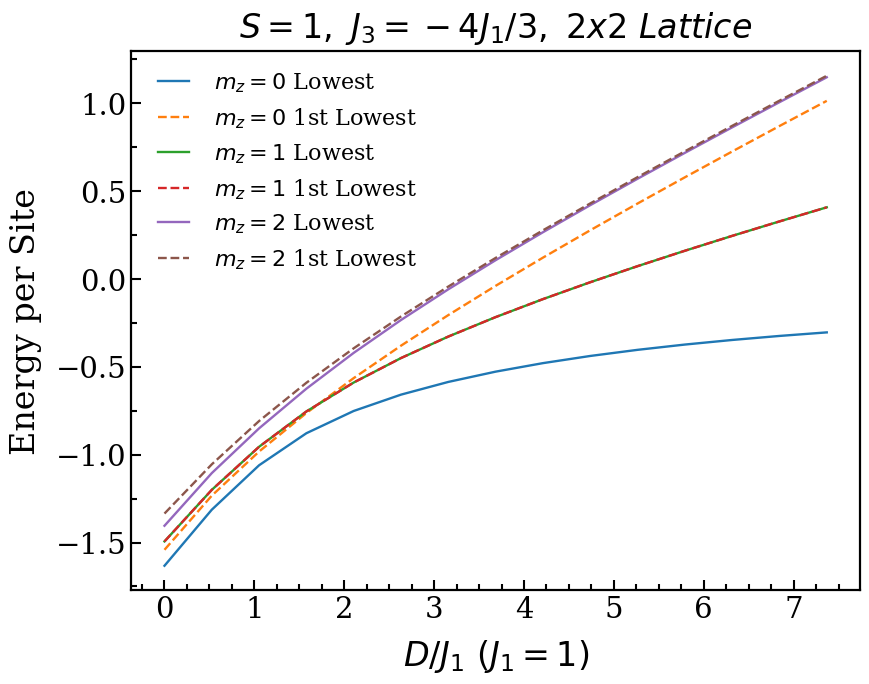

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('default')
mpl.rcParams["figure.figsize"]=(9.4,7)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.sans-serif'] = 'Computer Modern Roman'
mpl.rcParams['font.size'] = '10'
mpl.rcParams['text.usetex'] = False

s = 1
lx,ly = 2,2
TF = True
J1 = 1
factor = -4
J3 = factor*J1/3
mz1, mz2 = 1, 2

ground_energy0, ground_energy1, ground_energy2 = [], [], []
first_ex_energy0, first_ex_energy1, first_ex_energy2 = [], [], []
sec_ex_energy0, sec_ex_energy1, sec_ex_energy2 = [], [], []

if J1 == 1:
    g_list = np.linspace(0,10,20)
if J1 == -1:
    g_list = np.linspace(0,-10,20)

for g in g_list:
    D = g*J1

    en_evec0 = np.load \
    (f'D:\\Project\Data\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
    f'J3={round(J3,8)}\mz_0\Energy_Eigenvec\Energy_Eigenvec_g={round(g,8)}.npz')
    en_evec1 = np.load \
    (f'D:\\Project\Data\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
    f'J3={round(J3,8)}\mz_1\Energy_Eigenvec\Energy_Eigenvec_g={round(g,8)}.npz')
    en_evec2 = np.load \
    (f'D:\\Project\Data\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
    f'J3={round(J3,8)}\mz_2\Energy_Eigenvec\Energy_Eigenvec_g={round(g,8)}.npz')
    ground_energy0.append((en_evec0['energies'][0])/(2*lx*ly))
    first_ex_energy0.append((en_evec0['energies'][1])/(2*lx*ly))
    sec_ex_energy0.append((en_evec0['energies'][2])/(2*lx*ly))
    ground_energy1.append((en_evec1['energies'][0])/(2*lx*ly))
    first_ex_energy1.append((en_evec1['energies'][1])/(2*lx*ly))
    sec_ex_energy1.append((en_evec1['energies'][2])/(2*lx*ly))
    ground_energy2.append((en_evec2['energies'][0])/(2*lx*ly))
    first_ex_energy2.append((en_evec2['energies'][1])/(2*lx*ly))
    sec_ex_energy2.append((en_evec2['energies'][2])/(2*lx*ly))  

clip = 15
plt.plot(g_list[:clip],ground_energy0[:clip],lw=1.7,label=f'$m_z = 0$ Lowest')
plt.plot(g_list[:clip],first_ex_energy0[:clip],ls='--',lw=1.7,label=f'$m_z = 0$ 1st Lowest')
# plt.plot(g_list[:clip],sec_ex_energy0[:clip],label=f'$m_z = 0$ 2nd Lowest')
plt.plot(g_list[:clip],ground_energy1[:clip],lw=1.7,label=f'$m_z = 1$ Lowest')
plt.plot(g_list[:clip],first_ex_energy1[:clip],ls='--',lw=1.7,label=f'$m_z = 1$ 1st Lowest')
# plt.plot(g_list[:clip],sec_ex_energy1[:clip],label=f'$m_z = 1$ 2nd Lowest')
plt.plot(g_list[:clip],ground_energy2[:clip],lw=1.7,label=f'$m_z = 2$ Lowest')
plt.plot(g_list[:clip],first_ex_energy2[:clip],ls='--',lw=1.7,label=f'$m_z = 2$ 1st Lowest')
# plt.plot(g_list[:clip],sec_ex_energy2[:clip],label=f'$m_z = 2$ 2nd Lowest')
plt.xlabel(f'$D/J_1 \xa0 (J_1 = {J1})$',size=24,labelpad=10)
plt.ylabel('Energy per Site',size=24,labelpad=10)
plt.title(f'$S = {s},\ J_3 = {factor}J_1/3,\ {lx}x{ly} \ Lattice $',fontsize=24,pad=10)
if J1 == 1:
    if factor>0:
        plt.legend(loc='best',prop={'size':18}, fontsize=12,frameon=False,\
               labelspacing=.5, numpoints=2)
    elif factor<0:
        plt.legend(loc='best',prop={'size':16}, fontsize=12,frameon=False,\
               labelspacing=.5, numpoints=2)

elif J1 == -1:
    plt.legend(loc='best',prop={'size':17}, fontsize=12,frameon=False,\
               labelspacing=.5, numpoints=2)
plt.gca().spines['top'].set_linewidth(1.6)
plt.gca().spines['right'].set_linewidth(1.6)
plt.gca().spines['bottom'].set_linewidth(1.6)
plt.gca().spines['left'].set_linewidth(1.6)
plt.tick_params(axis='both', which='major',labelsize=21,direction='in', length=7, width=1.5)
plt.tick_params(axis='both', which='minor',direction='in', length=4, width=1.5)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.25))  
#plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.5))  
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.25))
if J1 == -1:
    plt.gca().invert_xaxis()
folder_name = \
f'D:\\Project\Plots\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'J3={round(J3,8)}'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
file_path = os.path.join(folder_name,f'Energies.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
plt.show()

### Second Derivative of Ground State

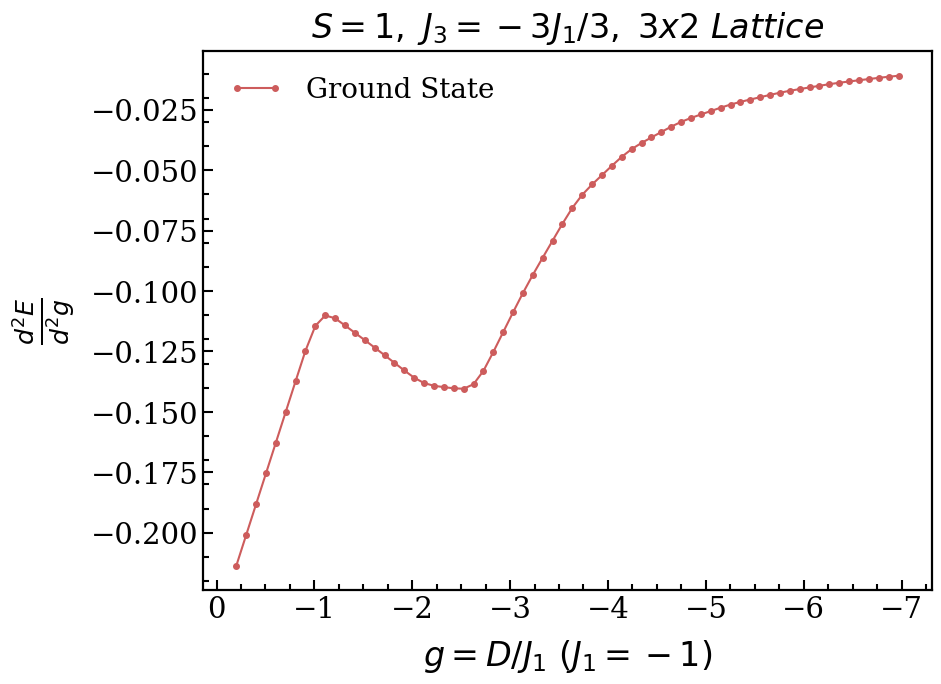

In [79]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('default')
mpl.rcParams["figure.figsize"]=(9.4,7)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.sans-serif'] = 'Computer Modern'
mpl.rcParams['font.size'] = '10'
mpl.rcParams['text.usetex'] = False

s = 1
lx,ly = 3,2
TF = True
J1 = -1
factor = -3
J3 = factor*J1/3
mz1, mz2 = 1, 2

if J1 == 1:
    g_list = np.linspace(0,10,20)
if J1 == -1:
    g_list = np.linspace(0,-10,20)
    
ground_energy = []
for g in g_list:
    en_evec0 = np.load \
    (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
    f'J3={round(J3,8)}\Energy_Eigenvec\Energy_Eigenvec_g={round(g,8)}.npz')
    
    ground_energy.append((en_evec0['all_energies'][0])/(2*lx*ly))

if J1 == 1:
    clip1 = 2
    clip2 = 70
if J1 == -1:
    clip1 = 30
    clip2 = 98
#interp_func = interp1d(g_list, ground_energy,kind='cubic')
if J1 == 1:
    interp_func = CubicSpline(g_list, ground_energy)
elif J1 == -1:
    interp_func = CubicSpline(g_list[::-1], ground_energy[::-1])
g_new = np.linspace(min(g_list), max(g_list), 100)
energy_interp = interp_func(g_new)
d1E_dg1_interp = np.gradient(energy_interp, g_new)
d2E_dg2_interp = np.gradient(d1E_dg1_interp, g_new)

#plt.plot(g_new,Energy_interp)
#plt.plot(g_new,energy_interp)
plt.plot(g_new[clip1:clip2],d2E_dg2_interp[clip1:clip2],marker='o',ms=4,c='IndianRed',\
         label=f'Ground State')
plt.xlabel(f'$g=D/J_1 \xa0 (J_1 = {J1})$',size=24,labelpad=10)
plt.ylabel(r'$\frac{d^{2}E}{d^{2}g}$',size=26,labelpad=10)
plt.title(f'$S = {s},\ J_3 = {factor}J_1/3,\ {lx}x{ly} \ Lattice $',fontsize=24,pad=10)
plt.legend(loc='best',prop={'size':20}, fontsize=12,frameon=False,\
           labelspacing=.5, numpoints=2)
plt.gca().spines['top'].set_linewidth(1.6)
plt.gca().spines['right'].set_linewidth(1.6)
plt.gca().spines['bottom'].set_linewidth(1.6)
plt.gca().spines['left'].set_linewidth(1.6)
plt.tick_params(axis='both', which='major',labelsize=21,direction='in', length=7, width=1.5)
plt.tick_params(axis='both', which='minor',direction='in', length=4, width=1.5)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.25))  
#plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.5))
if J1 == 1:
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.025))
if J1 == -1:
    if factor>0:
        plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.005))
    elif factor<0:
        plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.01))
if J1 == -1:
    plt.gca().invert_xaxis()
folder_name = \
f'D:\\IIT_Bombay\Project\Stage_2\Plots\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'J3={round(J3,8)}'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
file_path = os.path.join(folder_name,f'2nd_derivative_of_energy.png')
plt.savefig(file_path, dpi=260, bbox_inches='tight')
plt.show()

### All the functions

In [2]:
def mz_average(lx,ly,basis_list,eigenvec):
    summ = 0
    Ns = 2*lx*ly
    for basis,evec in zip(basis_list,eigenvec):
        mz = sum(basis)/Ns               # Per site
        #print(mz)
        summ += np.conj(evec)*mz*evec
    return summ

def mz_square_average(lx,ly,basis_list,eigenvec):
    summ = 0
    Ns = 2*lx*ly
    for basis,evec in zip(basis_list,eigenvec):
        mz = 0
        for k in range(Ns*Ns):  #substitute for: i in range(Ns) and then nested list j in range (Ns)
            i = k // Ns
            j = k % Ns
            mz += basis[i]*basis[j]
            #if j == Ns-1 :
                #print(mz)
        #print('-----')
        mz_site = mz/(Ns*Ns)               # Per site
        #print(mz_site)
        #print('------')
        summ += np.conj(evec)*mz_site*evec
    return summ

def staggerd_mz_avg(lx,ly,basis_list,eigenvec):
    Ns = 2*lx*ly
    summ = 0
    for basis,evec in zip(basis_list,eigenvec):
        mz = 0
        for site in range(Ns):
            b = site%2
            #print(b)
            #print(basis[site])
            mz += basis[site]*(-1)**b
        mz_site = mz/Ns
        #print(mz_site)
        #print('----')
        summ += np.conj(evec)*mz_site*evec
    return summ

def mod_staggerd_mz_avg(lx,ly,basis_list,eigenvec):
    Ns = 2*lx*ly
    summ = 0
    for basis,evec in zip(basis_list,eigenvec):
        mz = 0
        for site in range(Ns):
            b = site%2
            #print(b)
            #print(basis[site])
            mz += basis[site]*(-1)**b
        mz_site = mz/Ns
        #print(np.abs(mz_site))
        #print('----')
        summ += np.conj(evec)*np.abs(mz_site)*evec
    return summ

def square_staggerd_mz_avg(lx,ly,basis_list,eigenvec):
    Ns = 2*lx*ly
    summ = 0
    for basis,evec in zip(basis_list,eigenvec):
        mz = 0
        for k in range(Ns*Ns): #substitute for: i in range(Ns) and then nested list j in range (Ns)
            i = k // Ns
            j = k % Ns
            mod = (i+j)%2
            mz += basis[i]*basis[j]*(-1)**mod
#             if j == Ns-1 :
#                 print(mz)
#         print('-----')
        mz_site = mz/(Ns*Ns)
#         print(mz_site)
#         print('----')
        summ += np.conj(evec)*mz_site*evec
    return summ 

def quart_staggerd_mz_avg(lx,ly,basis_list,eigenvec):
    Ns = 2*lx*ly
    summ = 0
    for basis,evec in zip(basis_list,eigenvec):
        mz = 0
        for i in range(Ns):
            si = basis[i]
            for j in range(Ns):
                sj = basis[j]
                for k in range(Ns):
                    sk = basis[k]
                    for l in range(Ns):
                        sl = basis[l]
                        mod = (i+j+k+l)%2
                        mz += si*sj*sk*sl*(-1)**mod
                        
        mz_site = mz/(Ns**4)
#         print(mz_site)
#         print('----')
        summ += np.conj(evec)*mz_site*evec
    return summ 

def nematic_avg(lx,ly,basis_list,eigenvec):
    Ns = 2*lx*ly
    summ = 0
    for basis,evec in zip(basis_list,eigenvec):
        Q = 0
        for site in range(Ns):
            #print(basis[site])
            s0 = basis[site]
            Q += (s0*s0-(2/3))
        Q_site = Q/Ns
        #print(Q_site)
        #print('----')
        summ += np.conj(evec)*Q_site*evec
    return summ

def square_nematic_avg(lx,ly,basis_list,eigenvec):
    Ns = 2*lx*ly
    summ = 0
    for basis,evec in zip(basis_list,eigenvec):
        Q = 0
        for i in range(Ns):
            si = basis[i]
            Q += -si*si*(4/3)
            for j in range(Ns):
                sj = basis[j]
                Q += si*sj
        Q_site = Q/(Ns*Ns)        # Per site
        Q_new = Q_site+(4/9)
        #print(Q_new)
        #print('----')
        summ += np.conj(evec)*Q_new*evec
    return summ

### Storing Hamiltonian and Eigenvectors

#### J1 Part of Hamiltonian

In [4]:
s = 1
lx,ly = 2,2
J1 = -1
TF = True
mz = 0

folder_name_J1 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\Ham_matrices'

if not os.path.exists(folder_name_J1):
    os.makedirs(folder_name_J1)

start = time.time()
Ha_J1,Data,R,C,Ha_size,basis_list = Honey_ham_J1(lx,ly,s,J1,mz,TF)

if TF == True:
    J1_file = os.path.join(folder_name_J1,f'Sparse_ham_J1={J1}.npz')
    save_npz(J1_file,Ha_J1)
else:
    J1_file = os.path.join(folder_name_J1,f'Dense_ham_J1={J1}.npz')
    np.savez_compressed(J1_file,Ha_J1)

end = time.time()
print(f"\n Runtime is {round((end-start),4)} s") 


 Runtime is 0.4583 s


#### D Part of Hamiltonian

In [5]:
s = 1
lx,ly = 2,2
J1 = -1
TF = True
mz = 0

start = time.time()
folder_name_D = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\Ham_matrices'

if not os.path.exists(folder_name_D):
    os.makedirs(folder_name_D)

if J1 == 1:
    g_list = np.linspace(0,10,20)
if J1 == -1:
    g_list = np.linspace(0,-10,20)
for g in g_list:
    D = g*J1
    Ha_D,Data,R,C,Ha_size,basis_list = Honey_ham_D(lx,ly,s,D,mz,TF)
    
    if TF == True:
        file_name_D = f'Sparse_ham_D={round(D,8)}.npz'
        full_path_D = os.path.join(folder_name_D, file_name_D)
        save_npz(full_path_D, Ha_D)
    else:
        file_name_D = f'Dense_ham_D={round(D,8)}.npz'
        full_path_D = os.path.join(folder_name_D, file_name_D)
        np.savez_compressed(full_path_D, Ha_D)
    
end = time.time()
print(f"\n Runtime is {round((end-start),4)} s") 


 Runtime is 1.803 s


#### J3 Part of Hamiltonian

In [14]:
s = 1
lx,ly = 3,2
J1 = -1
TF = True
mz = 0
factor = -3
J3 = factor*J1/3

folder_name_J3 = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
f'J1={round(J1,8)}\J3={round(J3,8)}\Ham_matrices'

if not os.path.exists(folder_name_J3):
    os.makedirs(folder_name_J3)

start = time.time()
Ha_J3,Data,R,C,Ha_size,basis_list = Honey_ham_J3(lx,ly,s,J3,mz,TF)

if TF == True:
    J3_file = os.path.join(folder_name_J3,f'Sparse_ham_J3={round(J3,8)}.npz')
    save_npz(J3_file,Ha_J3)
else:
    J3_file = os.path.join(folder_name_J3,f'Dense_ham_J3={round(J3,8)}.npz')
    np.savez_compressed(J3_file,Ha_J3)

end = time.time()
print(f"\n Runtime is {round((end-start),4)} s") 


 Runtime is 7900.2433 s


#### Diagonalization

In [320]:
s = 1
lx,ly = 3,2
J1 = 1
TF = True
mz = 0
factor = 1
J3 = factor*J1/3

def mz_basis_list(lx,ly,s,mz):
    import itertools
    ls = [-1,0,1] if s == 1 else [0,1]
    Ns = 2*lx*ly           # Total number of spins
    basis_list = list(itertools.product(ls,repeat=Ns))
    mz_basis_list = []
    for bas in basis_list:
        summ = np.sum(bas)
        if summ == mz:
            mz_basis_list.append(bas)
    return mz_basis_list

basis_list = mz_basis_list(lx,ly,s,mz)

folder_name_ham = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'\J3={round(J3,8)}\Ham_matrices'

folder_name_en = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'\J3={round(J3,8)}\Energy_Eigenvec'

if not os.path.exists(folder_name_en):
    os.makedirs(folder_name_en)
    
start = time.time()
if TF == True:
    Ha_J1 = load_npz \
    (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
     f'J1={round(J1,8)}\Ham_matrices\Sparse_ham_J1={J1}.npz')
    Ha_J3 = load_npz \
    (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
     f'J1={round(J1,8)}\J3={round(J3,8)}\Ham_matrices\Sparse_ham_J3={round(J3,8)}.npz')
else:
    Ha_J1 = np.load \
    (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
    f'J1={round(J1,8)}\Ham_matrices\Dense_ham_J1={J1}.npz')
    #Ha_J1 =  Ham['arr_0']
    Ha_J3 = np.load \
    (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'\
     f'J1={round(J1,8)}\J3={round(J3,8)}\Ham_matrices\Sparse_ham_J3={round(J3,8)}.npz')

if J1 == 1:
    g_list = np.linspace(0,10,20)
if J1 == -1:
    g_list = np.linspace(0,-10,20)
for g in g_list:
    D = g*J1    
    
    if TF == True:
        Ha_D = load_npz \
        (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'
        f'\J1={round(J1,8)}\Ham_matrices\Sparse_ham_D={round(D,8)}.npz')
        Ha = Ha_J1 + Ha_J3 + Ha_D
        
        file_name = f'Sparse_ham_g={round(g,8)}.npz'
        full_path = os.path.join(folder_name_ham, file_name)
        save_npz(full_path, Ha)
    else:
        Ha_D = np.load \
        (f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\\'
        f'\J1={round(J1,8)}\Ham_matrices\Dense_ham_D={round(D,8)}.npz')
        Ha = Ha_J1 + Ha_J3 + Ha_D
        
        file_name = f'Dense_ham_g={round(g,8)}.npz'
        full_path = os.path.join(folder_name_ham, file_name)
        np.savez_compressed(full_path, Ha)
        
    if TF == True:
        V, W = eigsh(Ha,k=10,which='SA')
    else:
        V, W = np.linalg.eigh(Ha)
    
    energy0,energy1,energy2,energy3,energy4 = V[0], V[1], V[2], V[3], V[4]
    energies = np.array([energy0,energy1,energy2,energy3,energy4])
    evec0,evec1,evec2,evec3,evec4 = W[:,0], W[:,1], W[:,2], W[:,3], W[:,4]
    
    file_name = f'Energy_Eigenvec_g={round(g,8)}'
    full_path = os.path.join(folder_name_en, file_name)
    np.savez_compressed(full_path, basis=basis_list,all_energies=energies, eigenvec0=evec0, \
                        eigenvec1=evec1, eigenvec2=evec2, eigenvec3=evec3,  eigenvec4=evec4)

end = time.time()
print(f"\n Runtime is {round((end-start),4)} s") 


 Runtime is 2148.0687 s


### Storing Order Parameters

In [6]:
lx,ly = 3,2
s = 1
mz = 0
J1 = -1
factor = -1
J3 = factor*J1/3

def mz_basis_list(lx,ly,s,mz):
    import itertools
    ls = [-1,0,1] if s == 1 else [0,1]
    Ns = 2*lx*ly           # Total number of spins
    basis_list = list(itertools.product(ls,repeat=Ns))
    mz_basis_list = []
    for bas in basis_list:
        summ = np.sum(bas)
        if summ == mz:
            mz_basis_list.append(bas)
    return mz_basis_list

basis_list = mz_basis_list(lx,ly,s,mz)

folder_name_mop = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'J3={round(J3,8)}\Magnetic_order_params'
if not os.path.exists(folder_name_mop):
    os.makedirs(folder_name_mop)

if J1 == 1:
    g_list = np.linspace(0,10,20)
if J1 == -1:
    g_list = np.linspace(0,-10,20)

start = time.time()
for g in g_list:
    folder_name = \
    f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
    f'J3={round(J3,8)}\Energy_Eigenvec'
    file_name = f'Energy_Eigenvec_g={round(g,8)}.npz'
    full_path = os.path.join(folder_name,file_name)
    energy_eigenvectors = np.load(full_path)
    eigenvec = energy_eigenvectors['eigenvec0']

    mz_avg = mz_average(lx,ly,basis_list,eigenvec)
    mz_sq_avg = mz_square_average(lx,ly,basis_list,eigenvec)

    stg_mz_mod_avg = mod_staggerd_mz_avg(lx,ly,basis_list,eigenvec)

    stg_mz_avg = staggerd_mz_avg(lx,ly,basis_list,eigenvec)
    stg_mz_sq_avg = square_staggerd_mz_avg(lx,ly,basis_list,eigenvec)
    stg_mz_quart_avg = quart_staggerd_mz_avg(lx,ly,basis_list,eigenvec)

    nem_avg = nematic_avg(lx,ly,basis_list,eigenvec)
    nem_sq_avg = square_nematic_avg(lx,ly,basis_list,eigenvec)
    
    file_name_mop = f'Mag_OP_g={round(g,8)}'
    full_path_mop = os.path.join(folder_name_mop,file_name_mop)
    np.savez_compressed(full_path_mop, mz_average=mz_avg, mz_square_average=mz_sq_avg,\
                        staggered_mz_average=stg_mz_avg, staggered_mz_mod_average=stg_mz_mod_avg,\
            staggered_mz_square_average=stg_mz_sq_avg, staggered_mz_quartic_average=stg_mz_quart_avg,\
            nematic_average = nem_avg, nematic_square_average = nem_sq_avg)

end = time.time()
print(f"\n Runtime is {round((end-start),4)} s") 


 Runtime is 21568.9832 s


### Plotting

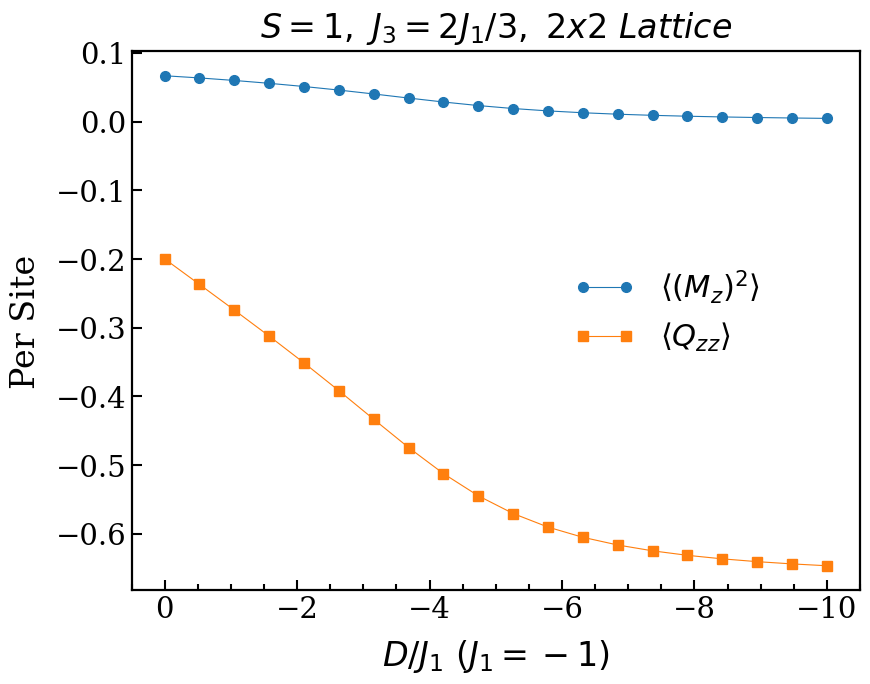

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('default')
mpl.rcParams["figure.figsize"]=(9.4,7)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.sans-serif'] = 'Computer Modern Roman'
mpl.rcParams['font.size'] = '10'
mpl.rcParams['text.usetex'] = False

lx,ly = 2,2
s = 1
mz = 0
J1 = -1
factor = 2
J3 = factor*J1/3

folder_name = \
f'C:\\Users\halde\Project\My Task\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'J3={round(J3,8)}\Magnetic_order_params'
if J1 == 1:
    g_list = np.linspace(0,10,20)
if J1 == -1:
    g_list = np.linspace(0,-10,20)

avg_mz, avg_sq_mz = [], []
avg_stg_mz, avg_mod_stg_mz, avg_sq_stg_mz, avg_quart_stg_mz = [], [], [], []
avg_nematic, avg_sq_nematic = [], []

for g in g_list:
    file_name = f'Mag_OP_g={round(g,8)}.npz'
    full_path = os.path.join(folder_name,file_name)
    Mag_O_params = np.load(full_path)
    avg_mz.append(Mag_O_params['mz_average'])
    avg_sq_mz.append(Mag_O_params['mz_square_average'])
    avg_stg_mz.append(Mag_O_params['staggered_mz_average'])
    avg_mod_stg_mz.append(Mag_O_params['staggered_mz_mod_average'])
    avg_sq_stg_mz.append(Mag_O_params['staggered_mz_square_average'])
    avg_quart_stg_mz.append(Mag_O_params['staggered_mz_quartic_average'])
    avg_nematic.append(Mag_O_params['nematic_average'])
    avg_sq_nematic.append(Mag_O_params['nematic_square_average'])


#plt.plot(g_list,avg_mz,lw=0.8,marker='.',ms=6,label=r'$\langle M_z\rangle $')
#plt.plot(g_list,avg_sq_mz,lw=0.8,marker='2',ms=10,label=r'$\langle M_z^2\rangle $')
#plt.plot(g_list,avg_stg_mz,lw=0.8,marker='+',ms=8,label=r'$\langle M_z^{stg}\rangle$')
#plt.plot(g_list,avg_mod_stg_mz,lw=0.8,marker='^',ms=6,label=r'$\langle|M_z^{stg}|\rangle$')
if J1 == 1:
    plt.plot(g_list,avg_sq_stg_mz,lw=0.8,marker='o',ms=7,label=r'$\langle(M_z^{stg})^2\rangle$')
if J1 == -1:
    plt.plot(g_list,avg_sq_stg_mz,lw=0.8,marker='o',ms=7,label=r'$\langle(M_z)^2\rangle$')
#plt.plot(g_list,avg_quart_stg_mz,lw=0.8,marker='D',ms=6,label=r'$\langle(M_z^{stg})^4\rangle$')
plt.plot(g_list,avg_nematic,lw=0.8,marker='s',ms=7,label=r'$\langle Q_{zz} \rangle$')
#plt.plot(g_list,avg_sq_nematic,lw=0.8,marker='v',ms=6,label=r'$\langle Q_{zz}^2 \rangle$')
plt.xlabel(f'$D/J_1 \ (J_1 = {J1})$',fontsize=24,labelpad=10)
plt.ylabel(f'Per Site', fontsize=24,labelpad=10)
plt.title(f'$S = {s},\ J_3 = {factor}J_1/3,\ {lx}x{ly} \ Lattice $',fontsize=24,pad=10)
if J1 == -1:
    plt.legend(loc='best',prop={'size':22}, fontsize=12,frameon=False,bbox_to_anchor=(0.9, 0.65),\
           labelspacing=.5, numpoints=2)
if J1 == 1:
    plt.legend(loc='best',prop={'size':22}, fontsize=12,frameon=False,bbox_to_anchor=(0.96, 0.5),\
           labelspacing=.5, numpoints=2)
plt.gca().spines['top'].set_linewidth(1.6)
plt.gca().spines['right'].set_linewidth(1.6)
plt.gca().spines['bottom'].set_linewidth(1.6)
plt.gca().spines['left'].set_linewidth(1.6)
plt.tick_params(axis='both', which='major',labelsize=21,direction='in', length=7, width=1.5)
plt.tick_params(axis='both', which='minor',direction='in', length=4, width=1.5)
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.9))  
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
#plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.5))  
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.1))
if J1 == -1:
    plt.gca().invert_xaxis()
folder_name = \
f'D:\\IIT_Bombay\Project\Stage_2\Plots\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'J3={round(J3,8)}'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
file_path = os.path.join(folder_name,'Magnetization_nematic.png')
plt.savefig(file_path, dpi=260, bbox_inches='tight')
plt.show()

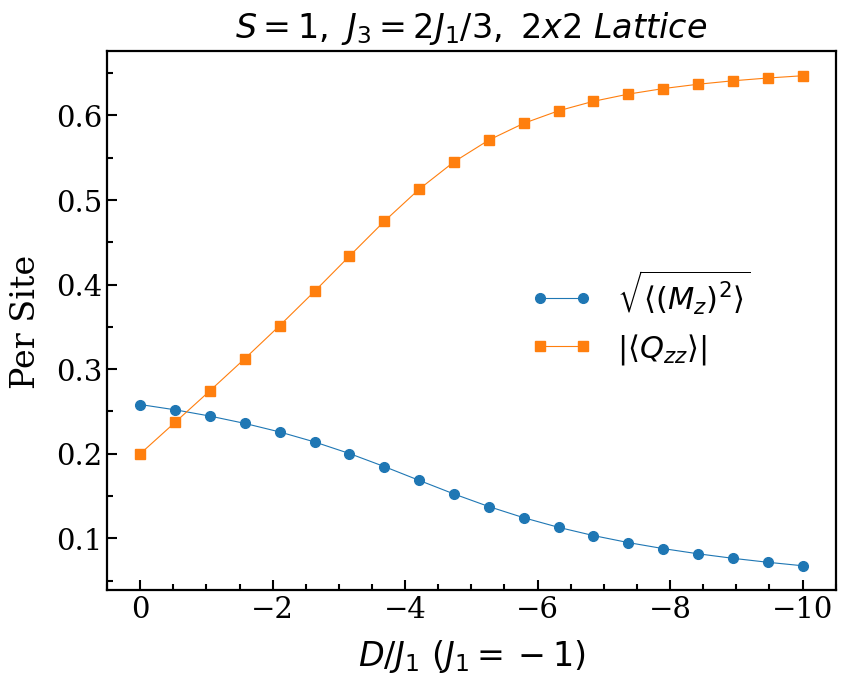

In [3]:
#plt.plot(g_list,avg_mod_stg_mz,lw=0.8,marker='^',ms=7,label=r'$\langle|M_z^{stg}|\rangle$')
if J1 == 1:
    plt.plot(g_list,np.sqrt(avg_sq_stg_mz),lw=0.8,marker='o',ms=7,\
                          label=r'$\sqrt{\langle(M_z^{stg})^2\rangle}$')
if J1 == -1:
    plt.plot(g_list,np.sqrt(avg_sq_stg_mz),lw=0.8,marker='o',ms=7,\
                          label=r'$\sqrt{\langle(M_z)^2\rangle}$')
plt.plot(g_list,np.abs(avg_nematic),lw=0.8,marker='s',ms=7,label=r'$|\langle Q_{zz} \rangle|$')
plt.xlabel(f'$D/J_1 \ (J_1 = {J1})$',fontsize=24,labelpad=10)
plt.ylabel(f'Per Site', fontsize=24,labelpad=10)
plt.title(f'$S = {s},\ J_3 = {factor}J_1/3,\ {lx}x{ly} \ Lattice $',fontsize=24,pad=10)
plt.legend(loc='best',prop={'size':22}, fontsize=13,frameon=False,bbox_to_anchor=(0.92, 0.65),\
           labelspacing=.5, numpoints=2)
plt.gca().spines['top'].set_linewidth(1.6)
plt.gca().spines['right'].set_linewidth(1.6)
plt.gca().spines['bottom'].set_linewidth(1.6)
plt.gca().spines['left'].set_linewidth(1.6)
plt.tick_params(axis='both', which='major',labelsize=21,direction='in', length=7, width=1.5)
plt.tick_params(axis='both', which='minor',direction='in', length=4, width=1.5)
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.9))  
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
#plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.5))  
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.05))
if J1 == -1:
    plt.gca().invert_xaxis()
folder_name = \
f'D:\\IIT_Bombay\Project\Stage_2\Plots\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'J3={round(J3,8)}'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
file_path = os.path.join(folder_name,'Nematic_crossing.png')
plt.savefig(file_path, dpi=260, bbox_inches='tight')
plt.show() 

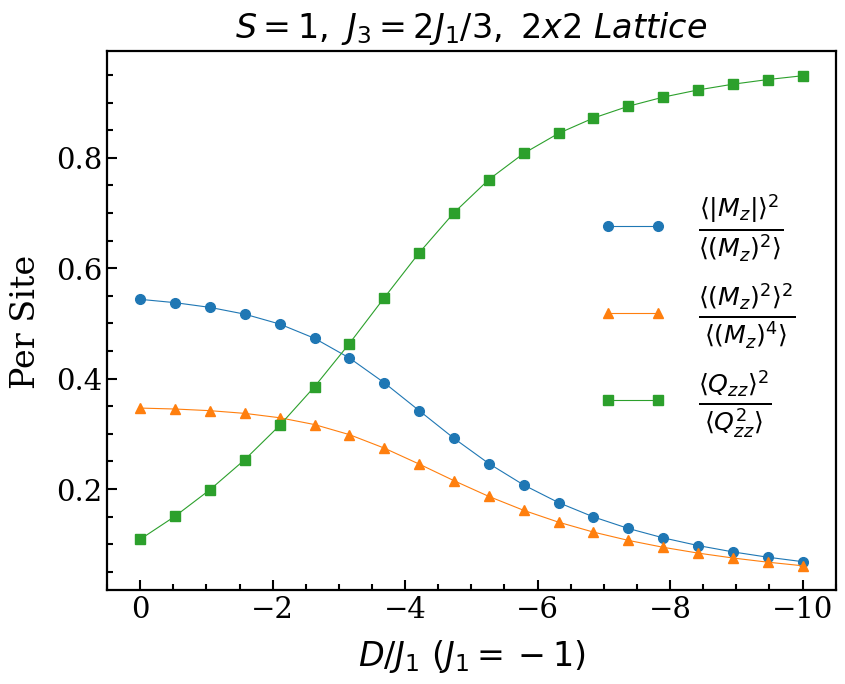

In [4]:
mz_ratio_list =np.square(avg_mod_stg_mz)/ avg_sq_stg_mz
mz4_ratio_list = np.square(avg_sq_stg_mz)/avg_quart_stg_mz
Q_ratio_list = np.square(avg_nematic)/avg_sq_nematic

if J1 == 1:
    plt.plot(g_list,mz_ratio_list,lw=0.8,marker='o',ms=7,\
             label=r'$\frac{\langle|M_z^{stg}|\rangle^2}{\langle(M_z^{stg})^2\rangle}$')
    plt.plot(g_list,mz4_ratio_list,lw=0.8,marker='^',ms=7,\
            label=r'$\frac{\langle (M_z^{stg})^2 \rangle^2}{\langle(M_z^{stg})^4\rangle}$')
if J1 == -1:
    plt.plot(g_list,mz_ratio_list,lw=0.8,marker='o',ms=7,\
         label=r'$\frac{\langle|M_z|\rangle^2}{\langle(M_z)^2\rangle}$')
    plt.plot(g_list,mz4_ratio_list,lw=0.8,marker='^',ms=7,\
        label=r'$\frac{\langle (M_z)^2 \rangle^2}{\langle(M_z)^4\rangle}$')
plt.plot(g_list,Q_ratio_list,lw=0.8,marker='s',ms=7,\
         label=r'$\frac{\langle Q_{zz} \rangle^2}{\langle Q_{zz}^2 \rangle}$')
plt.xlabel(f'$D/J_1 \ (J_1 = {J1})$',fontsize=24,labelpad=10)
plt.ylabel(f'Per Site', fontsize=24,labelpad=10)
plt.title(f'$S = {s},\ J_3 = {factor}J_1/3,\ {lx}x{ly} \ Lattice $',fontsize=24,pad=10)
if J1 == 1:
    if factor < 3 and factor > 0:
        plt.legend(loc='best',prop={'size':21}, fontsize=12,frameon=False,bbox_to_anchor=(0.99, 0.83),\
               labelspacing=.5, numpoints=2)
    elif factor < 0:
        plt.legend(loc='best',prop={'size':26}, fontsize=12,frameon=False,bbox_to_anchor=(0.95, 0.87),\
               labelspacing=.5, numpoints=2,)
    else:
        plt.legend(loc='best',prop={'size':22}, fontsize=12,frameon=False,bbox_to_anchor=(0.45, 0.665),\
               labelspacing=.5, numpoints=2, ncol=2)
if J1 == -1:
    if factor < 2 and factor > 0:
        plt.legend(loc='best',prop={'size':26}, fontsize=12,frameon=False,bbox_to_anchor=(0.99, 0.78),\
               labelspacing=.5, numpoints=2)
    elif factor == 2:
        plt.legend(loc='best',prop={'size':26}, fontsize=12,frameon=False,bbox_to_anchor=(0.99, 0.80),\
                   labelspacing=.5, numpoints=2)
    elif factor > 2:
#         plt.legend(loc='best',prop={'size':26}, fontsize=12,frameon=False,bbox_to_anchor=(0.99, 0.80),\
#                labelspacing=.5, numpoints=2)
        plt.legend(loc='best',prop={'size':23}, fontsize=12,frameon=False,bbox_to_anchor=(0.645, 0.6),\
               labelspacing=.5, numpoints=2, ncol=2)
    else:
         plt.legend(loc='best',prop={'size':26}, fontsize=12,frameon=False,bbox_to_anchor=(0.97, 0.83),\
               labelspacing=.5, numpoints=2)
plt.gca().spines['top'].set_linewidth(1.6)
plt.gca().spines['right'].set_linewidth(1.6)
plt.gca().spines['bottom'].set_linewidth(1.6)
plt.gca().spines['left'].set_linewidth(1.6)
plt.tick_params(axis='both', which='major',labelsize=21,direction='in', length=7, width=1.5)
plt.tick_params(axis='both', which='minor',direction='in', length=4, width=1.5)
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.9))  
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
#plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.5))  
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.05))
if J1 == -1:
    plt.gca().invert_xaxis()
folder_name = \
f'D:\\IIT_Bombay\Project\Stage_2\Plots\Honeycomb_{lx}x{ly}_1st_3rd_nbr\J1={round(J1,8)}\\'\
f'J3={round(J3,8)}'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
file_path = os.path.join(folder_name,'Binder_ratio_crossing.png')
plt.savefig(file_path, dpi=260, bbox_inches='tight')
plt.show()